In [1]:
import pandas as pd


df = pd.read_json(
    "agg_data/ParlaMint-SI.speeches.jsonl",
    lines=True,
    # nrows=10000
)
df = pd.concat([df, df.metadata.apply(pd.Series)], axis=1)


In [2]:

# Filtering
# Keep only speeches where speaker is either Opposition or Coalition:
c2 = df.Party_status.isin(["Opposition", "Coalition"])

# Keep only parties that have at least 10 speeches:
gb = df.groupby(["Speaker_party", "Party_status"]).logits_pondered.count().reset_index()
parties_to_keep = gb[gb.logits_pondered >= 10].Speaker_party.unique()
c3 = df.Speaker_party.isin(parties_to_keep)

ndf = df[c2&c3].reset_index(drop=True).dropna(subset="logits_pondered")
ndf.head(3)

,newdoc id,logits_pondered,logits_averaged,char_length,metadata,Text_ID,ID,Title,Date,Body,...,Speaker_MP,Speaker_minister,Speaker_party,Speaker_party_name,Party_status,Party_orientation,Speaker_ID,Speaker_name,Speaker_gender,Speaker_birth
0,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u1,2.497539,3.236904,1005,{'Text_ID': 'ParlaMint-SI-en_2022-04-06-SDZ8-I...,ParlaMint-SI-en_2022-04-06-SDZ8-Izredna-99,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u1,Minutes of the National Assembly of the Republ...,2022-04-06,Lower house,...,MP,notMinister,DeSUS,Demokratična stranka upokojencev Slovenije,Coalition,Centre to centre-left,SimonovičBranko,"Simonovič, Branko",M,1953
1,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u3,3.269488,3.741684,127,{'Text_ID': 'ParlaMint-SI-en_2022-04-06-SDZ8-I...,ParlaMint-SI-en_2022-04-06-SDZ8-Izredna-99,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u3,Minutes of the National Assembly of the Republ...,2022-04-06,Lower house,...,MP,notMinister,DeSUS,Demokratična stranka upokojencev Slovenije,Coalition,Centre to centre-left,SimonovičBranko,"Simonovič, Branko",M,1953
2,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u5,3.173941,3.532954,149,{'Text_ID': 'ParlaMint-SI-en_2022-04-06-SDZ8-I...,ParlaMint-SI-en_2022-04-06-SDZ8-Izredna-99,ParlaMint-SI_2022-04-06-SDZ8-Izredna-99.ana.u5,Minutes of the National Assembly of the Republ...,2022-04-06,Lower house,...,MP,notMinister,DeSUS,Demokratična stranka upokojencev Slovenije,Coalition,Centre to centre-left,SimonovičBranko,"Simonovič, Branko",M,1953


In [3]:
pd.set_option('display.max_rows', None)
gb1 = ndf.groupby(["Speaker_party", "Party_status"]).agg({
    "logits_pondered": ["mean", "count"]
}).reset_index()
gb1 = gb1.set_axis(gb1.columns.map(lambda l: '_'.join(l).rstrip("_").replace("logits_pondered_", "")), axis=1,)
gb2 = ndf.groupby(["Speaker_party"]).agg({
    "logits_pondered": ["mean", "count"]
}).reset_index()

gb2 = gb2.set_axis(gb2.columns.map(lambda l: '_'.join(l).rstrip("_").replace("logits_pondered_", "")), axis=1,)

gb2["Coalition_mean"] = gb2[["Speaker_party"]].merge(gb1[gb1["Party_status"]=="Coalition"], on="Speaker_party", how="left")["mean"]
gb2["Coalition_count"] = gb2[["Speaker_party"]].merge(gb1[gb1["Party_status"]=="Coalition"], on="Speaker_party", how="left")["count"]
gb2["Opposition_mean"] = gb2[["Speaker_party"]].merge(gb1[gb1["Party_status"]=="Opposition"], on="Speaker_party", how="left")["mean"]
gb2["Opposition_count"] = gb2[["Speaker_party"]].merge(gb1[gb1["Party_status"]=="Opposition"], on="Speaker_party", how="left")["count"]
gb2["Coal minus Oppo"] = gb2.Coalition_mean - gb2.Opposition_mean
gb2 = gb2.sort_values(by="count", ascending=False)
gb2

,Speaker_party,mean,count,Coalition_mean,Coalition_count,Opposition_mean,Opposition_count,Coal minus Oppo
11,SDS,2.502768,57218,2.874254,25481.0,2.204510,31737.0,0.669744
2,DeSUS,3.109033,38596,3.109147,37610.0,3.104691,986.0,0.004455
10,SD,2.711793,37075,2.900270,29523.0,1.974979,7552.0,0.925291
4,LDS,2.649487,29190,2.802955,18496.0,2.384054,10694.0,0.418901
14,SMC,2.846833,20960,2.846833,20960.0,NaN,NaN,NaN
16,SNS,2.465907,14158,NaN,NaN,2.465907,14158.0,NaN
7,NSi,2.239670,13495,2.529591,4805.0,2.079363,8690.0,0.450228
20,Zares,2.913386,12327,2.921332,11872.0,2.706057,455.0,0.215275
18,ZLSD,2.922559,11727,2.922559,11727.0,NaN,NaN,NaN
12,SLS,2.521070,8784,2.697369,5344.0,2.247192,3440.0,0.450177


<Axes: xlabel='Opposition_mean', ylabel='Coal minus Oppo'>

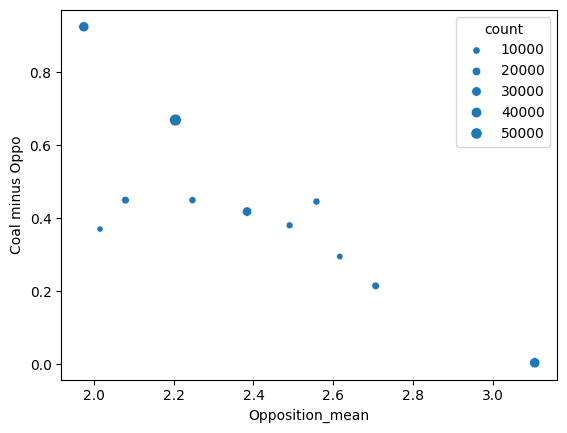

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=gb2,
    y = "Coal minus Oppo",
    x = "Opposition_mean",
    size="count"
)


<Axes: xlabel='Coalition_mean', ylabel='Opposition_mean'>

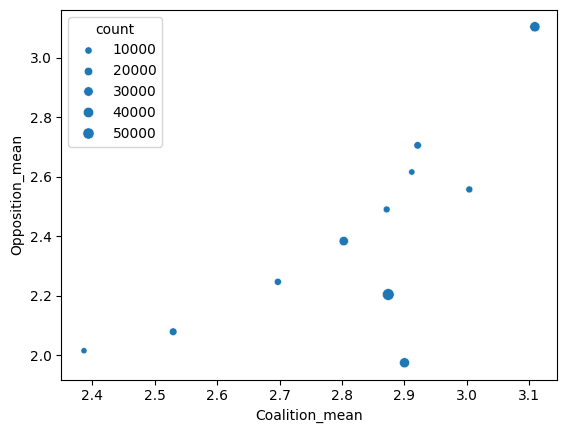

In [5]:
sns.scatterplot(
    data=gb2,
    x = "Coalition_mean",
    y = "Opposition_mean",
    size="count"
)

/home/peterr/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


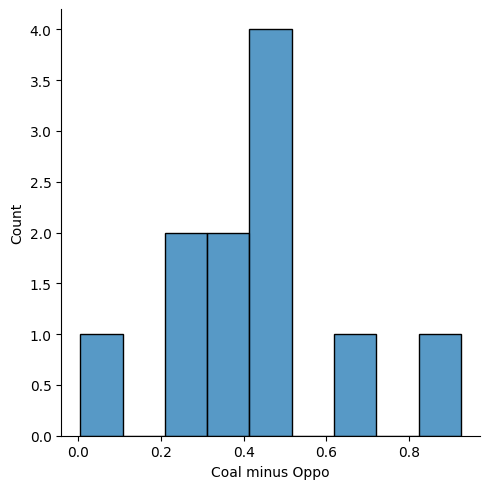

In [6]:
sns.displot(gb2, x="Coal minus Oppo")